# Cross-Validation and scoring methods

In the previous sections and notebooks, we split our dataset into two parts, a training set and a test set. We used the training set to fit our model, and we used the test set to evaluate its generalization performance -- how well it performs on new, unseen data.


<img src="figures/train_test_split.svg" width="100%">


However, often (labeled) data is precious, and this approach lets us only use ~ 3/4 of our data for training. On the other hand, we will only ever try to apply our model 1/4 of our data for testing.
A common way to use more of the data to build a model, but also get a more robust estimate of the generalization performance, is cross-validation.
In cross-validation, the data is split repeatedly into a training and non-overlapping test-sets, with a separate model built for every pair. The test-set scores are then aggregated for a more robust estimate.

The most common way to do cross-validation is k-fold cross-validation, in which the data is first split into k (often 5 or 10) equal-sized folds, and then for each iteration, one of the k folds is used as test data, and the rest as training data:

<img src="figures/cross_validation.svg" width="100%">


This way, each data point will be in the test-set exactly once, and we can use all but a k'th of the data for training.
Let us apply this technique to evaluate the KNeighborsClassifier algorithm on the Iris dataset:

In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

iris = load_iris()
X, y = iris.data, iris.target

classifier = KNeighborsClassifier()

The labels in iris are sorted, which means that if we split the data as illustrated above, the first fold will only have the label 0 in it, while the last one will only have the label 2:

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

To avoid this problem in evaluation, we first shuffle our data:

In [3]:
import numpy as np
rng = np.random.RandomState(0)

permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
print(y)

[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1
 2 0]


Now implementing cross-validation is easy:

In [4]:
k = 5
n_samples = len(X)
fold_size = n_samples // k
scores = []
masks = []
for fold in range(k):
    # generate a boolean mask for the test set in this fold
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[fold * fold_size : (fold + 1) * fold_size] = True
    # store the mask for visualization
    masks.append(test_mask)
    # create training and test sets using this mask
    X_test, y_test = X[test_mask], y[test_mask]
    X_train, y_train = X[~test_mask], y[~test_mask]
    # fit the classifier
    classifier.fit(X_train, y_train)
    # compute the score and record it
    scores.append(classifier.score(X_test, y_test))

Let's check that our test mask does the right thing:

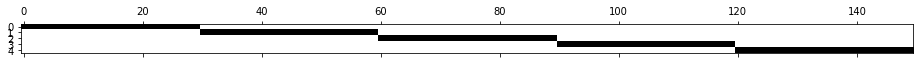

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(masks, cmap='gray_r')

And now let's look a the scores we computed:

In [6]:
print(scores)
print(np.mean(scores))

[0.9666666666666667, 0.9, 1.0, 1.0, 0.9333333333333333]
0.96


As you can see, there is a rather wide spectrum of scores from 90% correct to 100% correct. If we only did a single split, we might have gotten either answer.

As cross-validation is such a common pattern in machine learning, there are functions to do the above for you with much more flexibility and less code.
The ``sklearn.model_selection`` module has all functions related to cross validation. There easiest function is ``cross_val_score`` which takes an estimator and a dataset, and will do all of the splitting for you:

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y)
print('Scores on each CV fold: %s' % scores)
print('Mean score: %' np.mean(scores))

Score on CV fold: [0.98039216 0.98039216 0.95833333]
0.9730392156862745


As you can see, the function uses three folds by default. You can change the number of folds using the cv argument:

In [ ]:
cross_val_score(classifier, X, y, cv=5)

There are also helper objects in the cross-validation module that will generate indices for you for all kinds of different cross-validation methods, including k-fold:

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

By default, cross_val_score will use ``StratifiedKFold`` for classification, which ensures that the class proportions in the dataset are reflected in each fold. If you have a binary classification dataset with 90% of data point belonging to class 0, that would mean that in each fold, 90% of datapoints would belong to class 0.
If you would just use KFold cross-validation, it is likely that you would generate a split that only contains class 0.
It is generally a good idea to use ``StratifiedKFold`` whenever you do classification.

``StratifiedKFold`` would also remove our need to shuffle ``iris``.
Let's see what kinds of folds it generates on the unshuffled iris dataset.
Each cross-validation class is a generator of sets of training and test indices:

In [ ]:
cv = StratifiedKFold(n_splits=5)
for train, test in cv.split(iris.data, iris.target):
    print(test)

As you can see, there are a couple of samples from the beginning, then from the middle, and then from the end, in each of the folds.
This way, the class ratios are preserved. Let's visualize the split:

In [ ]:
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')

In [ ]:
plot_cv(StratifiedKFold(n_splits=5), iris.data, iris.target)

For comparison, again the standard KFold, that ignores the labels:

In [ ]:
plot_cv(KFold(n_splits=5), iris.data, iris.target)

Keep in mind that increasing the number of folds will give you a larger training dataset, but will lead to more repetitions, and therefore a slower evaluation:

In [ ]:
plot_cv(KFold(n_splits=10), iris.data, iris.target)

Another helpful cross-validation generator is ``ShuffleSplit``. This generator simply splits of a random portion of the data repeatedly. This allows the user to specify the number of repetitions and the training set size independently:

In [ ]:
plot_cv(ShuffleSplit(n_splits=5, test_size=.2), iris.data, iris.target)

If you want a more robust estimate, you can just increase the number of splits:

In [ ]:
plot_cv(ShuffleSplit(n_splits=20, test_size=.2), iris.data, iris.target)

You can use all of these cross-validation generators with the `cross_val_score` method:

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=.2)
cross_val_score(classifier, X, y, cv=cv)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Perform three-fold cross-validation using the ``KFold`` class on the iris dataset without shuffling the data. Can you explain the result?
      </li>
    </ul>
</div>

In [ ]:
# %load solutions/13_cross_validation.py